In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
d = [3]
print(d[-1])

3


In [ ]:
#### Step 1 import the necessary packages
print("Step 1 import the necessary packages")

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import pandas as pd
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import skimage.transform
from skimage import transform
from skimage.transform import rotate, AffineTransform

Step 1 import the necessary packages
Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#### Step 2 define the base path to the input dataset and then use it to derive the path to the input images and annotation CSV files

BASE_PATH = "gdrive/MyDrive/Colab Notebooks/ObjectRecognition/custom_dataset"
IMAGES_PATH = "gdrive/MyDrive/Colab Notebooks/ObjectRecognition/splitted_video_frames/noor_webcam_videoframes"
ANNOTS_PATH = "gdrive/MyDrive/ObjectRecognition/custom_dataset/annotations/"

# define the path to the base output directory
BASE_OUTPUT = "gdrive/MyDrive/Colab Notebooks/ObjectRecognition/custom_output"

# define the path to the output model, label binarizer, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "model_labels_classifier.h5"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])


In [ ]:
#### Step 3 find list of data, class labels, and image paths

# initialize the list of data (images), class labels, and image paths
data = []
labels = []
imagePaths = []

image_size = 112

# loop over all CSV files in the annotations directory
for csvPath in paths.list_files(ANNOTS_PATH, validExts=(".csv")):
    # load the contents of the current CSV annotations file
    rows = open(csvPath).read().strip().split("\n")




# loop over the rows
for idx, row in enumerate(rows):
    print("===============>     ", idx+1, "/", len(rows))

    # break the row into the filename, and class label
    row = row.split(",")
    (filename, startX, startY, endX, endY, label) = row

    # derive the path to the input image, load the image (in OpenCV format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)

    # derive the path to the input image, load the image and preprocess it
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = load_img(imagePath, target_size=(image_size, image_size))
    image = img_to_array(image)

    # Grab np array image dimensions
    (h, w) = image.shape[:2]


    # update our list of data, class labels, bounding boxes, and image paths
    data.append(image)
    labels.append(label)
    imagePaths.append(imagePath)
    

# convert the data, class labels, and image paths to NumPy arrays. Then scale the input pixel intensities from the range[0, 255] to [0, 1]
data = np.array(data)/ 255.0
labels = np.array(labels)
imagePaths = np.array(imagePaths)



===============>      1 / 1407
===============>      2 / 1407
===============>      3 / 1407
===============>      4 / 1407
===============>      5 / 1407
===============>      6 / 1407
===============>      7 / 1407
===============>      8 / 1407
===============>      9 / 1407
===============>      10 / 1407
===============>      11 / 1407
===============>      12 / 1407
===============>      13 / 1407
===============>      14 / 1407
===============>      15 / 1407
===============>      16 / 1407
===============>      17 / 1407
===============>      18 / 1407
===============>      19 / 1407
===============>      20 / 1407
===============>      21 / 1407
===============>      22 / 1407
===============>      23 / 1407
===============>      24 / 1407
===============>      25 / 1407
===============>      26 / 1407
===============>      27 / 1407
===============>      28 / 1407
===============>      29 / 1407
===============>      30 / 1407
===============>      31 / 1407
===============> 

In [ ]:
import time
start_time = time.time()
# Image augmentation

data_list = []
labels_list = []

# Print progress bar
def print_progress(idx, total_idx, start_time):
    time_elapsed = round((time.time() - start_time) /60, 1)
    progress_string = '==========> ' + str(idx) + '/' + str(total_idx) + ', ' + str(time_elapsed) + ' minutes'
    print(progress_string)



start_time = time.time()

for idx, data_item in enumerate(data):

    print_progress(idx+1, len(data), start_time)

    # Rotation
    # Placeholders: 'x' = A single image, 'y' = A batch of images
    # 'k' denotes the number of 90 degree anticlockwise rotations
    shape = [h, w, 3]
    x = tf.placeholder(dtype = tf.float32, shape = shape)
    rot_90 = tf.image.rot90(data_item, k=1)
    rot_180 = tf.image.rot90(data_item, k=2)
    rot_270 = tf.image.rot90(data_item, k=3)
    rot_90 = rot_90.eval(session=tf.compat.v1.Session()) #convert tensor in numpy array
    rot_180 = rot_180.eval(session=tf.compat.v1.Session()) #convert tensor in numpy array
    rot_270 = rot_270.eval(session=tf.compat.v1.Session()) #convert tensor in numpy array
    
     
    # Scikit-Image. 'angle' = Degrees. 'img' = Input Image
    # For details about 'mode', checkout the interpolation section below.
    rot_45 = skimage.transform.rotate(data_item, angle=45, mode='edge')
    rot_135 = skimage.transform.rotate(data_item, angle=135, mode='edge')
    rot_225 = skimage.transform.rotate(data_item, angle=225, mode='edge')
    rot_315 = skimage.transform.rotate(data_item, angle=315, mode='edge')


    # Brightness
    bright = tf.image.adjust_brightness(data_item, 0.4)
    bright = bright.eval(session=tf.compat.v1.Session())

    # Adding Gaussian noise
    noise = tf.random_normal(shape=tf.shape(data_item), mean=0.0, stddev=0.4, dtype=tf.float32)
    gaussian_noise = tf.add(data_item, noise)
    gaussian_noise = gaussian_noise.eval(session=tf.compat.v1.Session())

    # Shearing
    af = AffineTransform(shear=-0.5)
    sheared = transform.warp(data_item, af, order=1, preserve_range=True, mode='constant') 

    # sheared_rot90 = transform.warp(rot_90, af, order=1, preserve_range=True, mode='constant')
    # sheared_rot180 = transform.warp(rot_180, af, order=1, preserve_range=True, mode='constant')
    # sheared_rot270 = transform.warp(rot_270, af, order=1, preserve_range=True, mode='constant')
    # sheared_rot45 = transform.warp(rot_45, af, order=1, preserve_range=True, mode='constant')
    # sheared_rot135 = transform.warp(rot_135, af, order=1, preserve_range=True, mode='constant')
    # sheared_rot225 = transform.warp(rot_225, af, order=1, preserve_range=True, mode='constant')
    # sheared_rot315 = transform.warp(rot_315, af, order=1, preserve_range=True, mode='constant')
    # sheared_bright = transform.warp(bright, af, order=1, preserve_range=True, mode='constant')
    # sheared_gaussian_noise = transform.warp(gaussian_noise, af, order=1, preserve_range=True, mode='constant')


    # Append augmented images in a list
    data_list.append(rot_90)
    data_list.append(rot_180)
    data_list.append(rot_270)
    data_list.append(rot_45)
    data_list.append(rot_135)
    data_list.append(rot_225)
    data_list.append(rot_315)
    data_list.append(bright)
    data_list.append(gaussian_noise)
    data_list.append(sheared)

    # data_list.append(sheared_rot90)
    # data_list.append(sheared_rot180)
    # data_list.append(sheared_rot270)
    # data_list.append(sheared_rot45)
    # data_list.append(sheared_rot135)
    # data_list.append(sheared_rot225)
    # data_list.append(sheared_rot315)
    # data_list.append(sheared_bright)
    # data_list.append(sheared_gaussian_noise)
 


    # Append labels of augmented images in a list
    for x in range(10):
        label = labels[idx]
        labels_list.append(label)

data = list(data)
labels = list(labels)

# Concatenate the orginal images list with augmneted images list
for x in data_list:
    data.append(x)


# Concatenate the orginal image labels list with augmneted images labes list
for x in labels_list:
    labels.append(x)



In [ ]:
#perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [ ]:
np.save('gdrive/MyDrive/Colab Notebooks/ObjectRecognition/custom_output/datanp.npy', data)
np.save('gdrive/MyDrive/Colab Notebooks/ObjectRecognition/custom_output/labelnp.npy', labels)

In [ ]:
#### Step 4 partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing

split = train_test_split(data, labels, test_size=0.20, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:]

In [ ]:
# initialize our initial learning rate, number of epochs to train for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 30

In [ ]:
# define dictionaries
losses = {"class_label": "categorical_crossentropy"}
trainTargets = {"class_label": trainLabels}
testTargets = {"class_label": testLabels}

NameError: ignored

In [ ]:
# Conversting 3D array into 4D array
train_images = list(trainImages)
train_images = np.concatenate([arr[np.newaxis] for arr in train_images])


test_images = list(testImages)
test_images = np.concatenate([arr[np.newaxis] for arr in test_images])


In [ ]:
# Part 2 - Building the CNN

# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution and pooling layer
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[image_size, image_size, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional and pooling layer
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a third convolutional layer and pooling
cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=512, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=len(lb.classes_), activation="softmax"))

# Part 3 - Training the CNN

# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics = ['accuracy'])

print(cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0

In [ ]:
# Training the CNN on the Training set and evaluating it on the Test set
H = cnn.fit(train_images, trainLabels, validation_data=(test_images, testLabels),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1)

Train on 1125 samples, validate on 282 samples
Epoch 1/20
1125/1125 [==============================] - 5s 4ms/sample - loss: 1.1552 - acc: 0.5618 - val_loss: 0.2501 - val_acc: 0.9220
Epoch 2/20
 180/1125 [===>..........................] - ETA: 0s - loss: 0.3616 - acc: 0.8667

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1125/1125 [==============================] - 0s 422us/sample - loss: 0.2070 - acc: 0.9404 - val_loss: 0.0405 - val_acc: 0.9858
Epoch 3/20
1125/1125 [==============================] - 0s 416us/sample - loss: 0.0568 - acc: 0.9796 - val_loss: 0.0137 - val_acc: 1.0000
Epoch 4/20
1125/1125 [==============================] - 0s 416us/sample - loss: 0.0562 - acc: 0.9858 - val_loss: 0.0352 - val_acc: 0.9787
Epoch 5/20
1125/1125 [==============================] - 0s 425us/sample - loss: 0.0175 - acc: 0.9947 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 6/20
1125/1125 [==============================] - 0s 411us/sample - loss: 0.0015 - acc: 1.0000 - val_loss: 7.9010e-04 - val_acc: 1.0000
Epoch 7/20
1125/1125 [==============================] - 0s 417us/sample - loss: 7.3375e-04 - acc: 1.0000 - val_loss: 7.6549e-04 - val_acc: 1.0000
Epoch 8/20
1125/1125 [==============================] - 0s 407us/sample - loss: 3.0754e-04 - acc: 1.0000 - val_loss: 4.6007e-04 - val_acc: 1.0000
Epoch 9/20
1125/1125 [===

In [ ]:
# serialize the model to disk
print("[INFO] saving label classifier model...")
cnn.save(MODEL_PATH, save_format="h5")


# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving label classifier model...
[INFO] saving label binarizer...


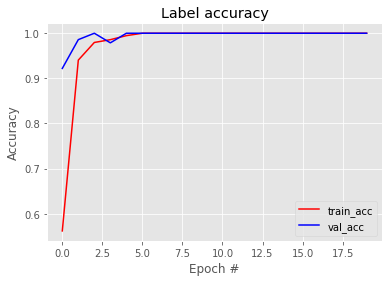

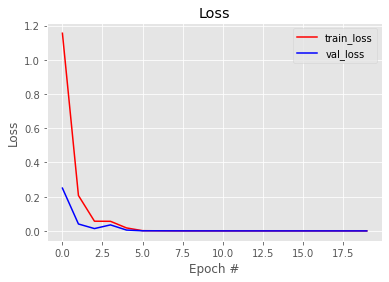

In [ ]:
#### Step 7 Plotting the accuracy of training and test set on epocs

# create a new figure for the accuracies
N = np.arange(0, NUM_EPOCHS)

plot1 = plt.figure(1)
plt.style.use("ggplot")
plt.plot(N, H.history["acc"], color='red', label="train_acc")
plt.plot(N, H.history["val_acc"], color='blue', label="val_acc")
plt.title("Label accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plot2 = plt.figure(2)
plt.style.use("ggplot")
plt.plot(N, H.history["loss"], color='red', label="train_loss")
plt.plot(N, H.history["val_loss"], color='blue', label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.show()

In [ ]:
image = np.expand_dims(test_images[150], axis=0)
labelPreds = cnn.predict(image)
i = np.argmax(labelPreds, axis=1)
print(i)
label = lb.classes_[i][0]
print(label)


[2]
drink-cappucchino-familyCappuccino-cafet


In [ ]:
print(testLabels[150])


[0 0 1 0 0 0]


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os
import numpy as np
import cv2
from PIL import Image


# define the path to the base output directory
BASE_OUTPUT = "gdrive/MyDrive/Colab Notebooks/ObjectRecognition/custom_output"

# define the path to the output model, label binarizer, plots output directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "model_labels_classifier.h5"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])

# load our object detector and label binarizer from disk
print("[INFO] loading object classifier...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(LB_PATH, "rb").read())

image = np.expand_dims(test_images[150], axis=0)
labelPreds = model.predict(image)
i = np.argmax(labelPreds, axis=1)
label = lb.classes_[i][0]
print(label)

[INFO] loading object classifier...
drink-cappucchino-familyCappuccino-cafet


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
